# Multi-Omics Analysis for LUSC Survival Prediction

Bla



## Imports and helper functions

In [1]:
import os,shutil,io,json,glob,tarfile,requests
import functools

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines

from pypgatk.cgenomes.cbioportal_downloader import CbioPortalDownloadService

In [2]:
def untar_study(study, output_directory, fmt=".tar.gz"):
    file = tarfile.open(
        os.path.join(
            output_directory,
            "{study}{format}".format(study=study, format=fmt)
            )
        )
    file.extractall(output_directory)
    file.close()

In [3]:
def download_cbioportal_study(
        config_file,
        study,
        output_directory = "./data",
        list_studies = False,
        multithreading = True,
        **kwargs
        ):
    pipeline_arguments = {
        CbioPortalDownloadService.CONFIG_OUTPUT_DIRECTORY: output_directory,
        CbioPortalDownloadService.CONFIG_LIST_STUDIES: list_studies,
        CbioPortalDownloadService.CONFIG_MULTITHREADING: multithreading,
        **kwargs,
    } 
    cbioportal_downloader_service = CbioPortalDownloadService(config_file, pipeline_arguments)
    cbioportal_downloader_service.download_study(study)

In [4]:
def get_mirna_files(
        project_id="TCGA-LUSC",
        maxfiles=10000
        ):

    cases_endpt = "https://api.gdc.cancer.gov/files"
    data_endpt = "https://api.gdc.cancer.gov/data"

    # Retrieve associated file names
    filters = {
        "op": "and",
        "content":[
            {"op": "=",
            "content":{
                "field": "cases.project.project_id",
                "value": ["TCGA-LUSC"]
                }
            },
            {"op": "=",
            "content":{
                "field": "files.experimental_strategy",
                "value": ["miRNA-Seq"]
                }
            },
            {"op": "=",
            "content":{
                "field": "files.data_category",
                "value": ["Transcriptome Profiling"]
                }
            },
            {"op": "=",
            "content":{
                "field": "files.data_type",
                "value": ["miRNA Expression Quantification"]
                }
            }
        ]
    }

    params = {
        "filters": json.dumps(filters),
        "fields": ",".join(["cases.submitter_id","file_name"]),
        "format": "TSV",
        "size": str(maxfiles)
    }

    response = requests.get(cases_endpt, params = params)
    files_df = pd.read_csv(io.StringIO(response.text), sep="\t")
    return files_df

def download_mirna_files(
        files_df,
        output_directory = "./data",
        project_id="TCGA-LUSC",
        maxfiles=10000
        ):
    
    params = {"ids": files_df["id"].tolist()}

    response = requests.post(data_endpt,
                            data = json.dumps(params),
                            headers={
                                "Content-Type": "application/json"
                                })

    response_head_cd = response.headers["Content-Disposition"]
    file_name = re.findall("filename=(.+)", response_head_cd)[0]
    with open(os.path.join(output_directory, file_name), "wb") as output_file:
        output_file.write(response.content)
    return file_name

In [5]:
def untar_and_merge_mirna_files(
        files_df,
        file_name,
        output_directory = "./data",
        cleanup=True
        ):
    untar_study(file_name, output_directory, fmt="")
    
    miRNA_IDs = set()
    patient_dfs = {}
    patient_folders = []
    for i in range(len(files_df)):
        patient_id = files_df["cases.0.submitter_id"].iloc[i]
        foldername = files_df["id"].iloc[i]
        patient_fname = os.listdir(os.path.join(output_directory, foldername))[0]
        patient_df = pd.read_csv(os.path.join(output_directory, foldername, patient_fname), sep="\t")
        
        miRNA_IDs.update(patient_df["miRNA_ID"].tolist())
        patient_dfs[patient_id] = patient_df
        patient_folders.append(foldername)
    
    miRNA_df = pd.DataFrame({"patient_id":[], **{k:[] for k in miRNA_IDs}}).set_index("patient_id")
    for patient_id in patient_dfs:
        patient_df = patient_dfs[patient_id]
        patient_id = "{}-01".format(patient_id) # This line is to match cBioPortal's format
        transposed_patient_df = patient_df[["miRNA_ID","reads_per_million_miRNA_mapped"]].set_index("miRNA_ID").transpose()
        transposed_patient_df["patient_id"] = [patient_id]
        transposed_patient_df = transposed_patient_df.set_index("patient_id")
        miRNA_df.loc[patient_id,miRNA_df.columns] = transposed_patient_df[miRNA_df.columns].values.flatten()
        
    if cleanup:
        for patient_folder in patient_folders:
            shutil.rmtree(os.path.join(output_directory, patient_folder))
    
    return miRNA_df

In [6]:
def remove_constant_columns(df):
    columns_to_remove = []
    for idx, column in enumerate(df.columns):
        try:
            if (df[column].std() == 0).any():
                columns_to_remove.append(column)
        except KeyError:
            columns_to_remove.append(column)
    return df.drop(columns=columns_to_remove)

## Data Acquisition and Pre-Processing

### Acquiring data from cBioPortal

In [7]:
cbioportal_config = "./config/cbioportal_config.yaml"
data_directory = "./data"
study_name = "lusc_tcga"

In [8]:
download_cbioportal_study(cbioportal_config, study_name, data_directory)

In [9]:
untar_study(study_name, data_directory, fmt=".tar")

In [10]:
clinical_data = pd.read_csv(os.path.join(data_directory, study_name, "data_bcr_clinical_data_patient.txt"), comment="#", sep="\t").set_index("PATIENT_ID").drop(columns="OTHER_PATIENT_ID")
clinical_data.describe()

,FORM_COMPLETION_DATE,HISTOLOGICAL_DIAGNOSIS,PROSPECTIVE_COLLECTION,RETROSPECTIVE_COLLECTION,SEX,RACE,ETHNICITY,LATERALITY,HISTORY_OTHER_MALIGNANCY,PRIMARY_SITE_PATIENT,...,POS_LYMPH_NODE_LOCATION,PROJECT_CODE,STAGE_OTHER,TARGETED_MOLECULAR_THERAPY,TISSUE_SOURCE_SITE,SITE_OF_TUMOR_TISSUE,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS
count,504,504,504,504,504,504,504,504,504,504,...,504,504,504,504,504,504,504,504,504,504
unique,199,1,3,3,2,4,3,1,5,9,...,1,1,1,3,35,1,2,439,3,328
top,3/7/11,Lung Squamous Cell Carcinoma,NO,YES,Male,WHITE,NOT HISPANIC OR LATINO,[Not Available],No,L-Upper,...,[Not Available],[Not Available],[Not Available],[Not Available],85,Lung,0:LIVING,2,0:DiseaseFree,[Not Available]
freq,39,504,326,326,373,351,319,504,433,137,...,504,504,504,350,50,504,284,8,245,127


In [11]:
# Drop unused columns
clinical_data = clinical_data[["OS_STATUS", "OS_MONTHS", "DFS_STATUS", "DFS_MONTHS"]]
# Add a binary column with the status
clinical_data["OS_STATUS_B"] = clinical_data["OS_STATUS"]=="1:DECEASED"
clinical_data["OS_MONTHS"] = pd.to_numeric(clinical_data["OS_MONTHS"], errors="coerce")
clinical_data = clinical_data.dropna()

In [12]:
clinical_data[np.logical_not(clinical_data["OS_STATUS_B"])]

,OS_STATUS,OS_MONTHS,DFS_STATUS,DFS_MONTHS,OS_STATUS_B
PATIENT_ID,,,,,
TCGA-18-3409,0:LIVING,123.09,1:Recurred/Progressed,75.26,False
TCGA-18-3411,0:LIVING,117.48,0:DiseaseFree,117.48,False
TCGA-18-3419,0:LIVING,92.35,0:DiseaseFree,92.35,False
TCGA-18-3421,0:LIVING,86.89,0:DiseaseFree,86.89,False
TCGA-18-4721,0:LIVING,154.20,0:DiseaseFree,154.2,False
...,...,...,...,...,...
TCGA-NK-A5CR,0:LIVING,83.51,0:DiseaseFree,83.51,False
TCGA-NK-A5CT,0:LIVING,65.60,1:Recurred/Progressed,65.37,False
TCGA-NK-A5CX,0:LIVING,3.65,0:DiseaseFree,3.65,False


In [13]:
clinical_data.describe()

,OS_MONTHS
count,498.000000
mean,31.949920
std,31.603341
min,0.000000
25%,10.682500
50%,21.895000
75%,41.382500
max,173.690000


<AxesSubplot:xlabel='timeline'>

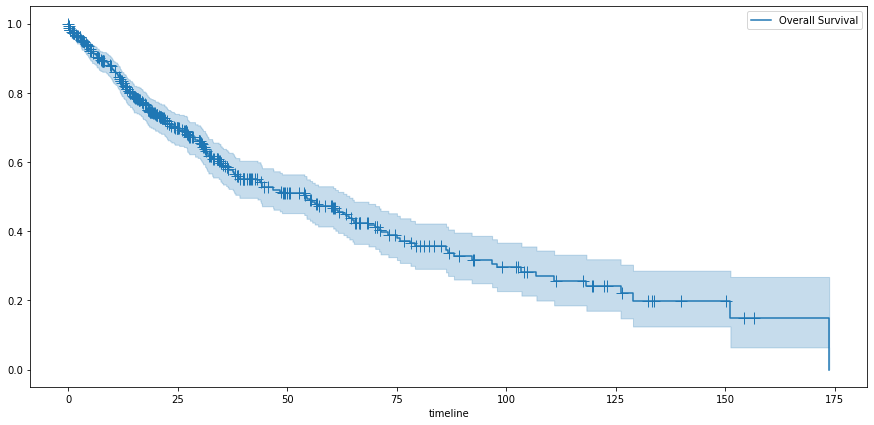

In [14]:
kmf = lifelines.KaplanMeierFitter(label="Overall Survival")
kmf.fit(durations=clinical_data["OS_MONTHS"],
        event_observed=clinical_data["OS_STATUS_B"])
plt.figure(figsize=(15,7))
kmf.plot(show_censors=1, ci_show=1)

In [15]:
RNAseq = pd.read_csv(os.path.join(data_directory, study_name, "data_RNA_Seq_v2_expression_median.txt"), comment="#", sep="\t").set_index("Hugo_Symbol").drop(columns="Entrez_Gene_Id")
linearCNA = pd.read_csv(os.path.join(data_directory, study_name, "data_linear_CNA.txt"), comment="#", sep="\t").set_index("Hugo_Symbol").drop(columns="Entrez_Gene_Id")
methylation_hm450 = pd.read_csv(os.path.join(data_directory, study_name, "data_methylation_hm450.txt"), comment="#", sep="\t").set_index("Hugo_Symbol").drop(columns="Entrez_Gene_Id")

len(RNAseq), len(linearCNA), len(methylation_hm450)

(20531, 24776, 16714)

Remove any constant columns

In [16]:
RNAseq_t = remove_constant_columns(RNAseq.transpose())
RNAseq = RNAseq_t.transpose()
linearCNA_t = remove_constant_columns(linearCNA.transpose())
linearCNA = linearCNA_t.transpose()
methylation_hm450_t = remove_constant_columns(methylation_hm450.transpose())
methylation_hm450 = methylation_hm450_t.transpose()

len(RNAseq), len(linearCNA), len(methylation_hm450)

(20242, 24776, 16714)

### miRNA data from gdc.cancer.gov

In [17]:
mirna_files_df = get_mirna_files()
mirna_files_df.describe()

,cases.0.submitter_id,file_name,id
count,523,523,523
unique,478,523,523
top,TCGA-43-6771,7df584d3-5b11-4987-8227-6d809e8305af.mirbase21...,07fa22d0-99b1-4364-9b93-d937005a2416
freq,2,1,1


In [18]:
mirna_fname = download_mirna_files(mirna_files_df, data_directory)
#mirna_fname = "gdc_download_20211114_175949.738652.tar.gz"

In [19]:
miRNA_df_t = untar_and_merge_mirna_files(mirna_files_df, mirna_fname, data_directory)
print("All columns:", len(miRNA_df_t.columns))
miRNA_df_t = remove_constant_columns(miRNA_df_t)
print("Only non-constant columns:", len(miRNA_df_t.columns))
miRNA_df = miRNA_df_t.transpose()

All columns: 1881
Only non-constant columns: 1579


## Reconciling data from cBioPortal and gdc.cancer.gov

In [20]:
RNAseq_patients = set(RNAseq_t.index)
linearCNA_patients = set(linearCNA_t.index)
methylation_hm450_patients = set(methylation_hm450_t.index)
miRNA_patients = set(miRNA_df_t.index)
all_sets = [RNAseq_patients, linearCNA_patients, methylation_hm450_patients, miRNA_patients]
all_patients = functools.reduce(lambda x, y: x|y, all_sets, set())
patients_on_all_datasets = functools.reduce(lambda x, y: x&y, all_sets, all_patients)

In [21]:
list(map(len, all_sets))

[501, 501, 370, 478]

In [22]:
len(all_patients), len(patients_on_all_datasets)

(504, 362)